# Полносвязная нейронная сеть

![NN](imgs/nn.png)

## $ y = Softmax( \phi_4( \phi_3 ( (\phi_2 ( \phi_1 ( X W_1 + b_1 ) W_2 + b_2  ) ) W_3 + b_3) W_4 + b_4 ) ) $

--------

In [1]:
import numpy as np

In [2]:
scores = np.arange(3).reshape(1,3)
print(scores)

[[0 1 2]]


In [3]:
def softmax_naive(x):
    denom = np.sum(np.exp(x))
    s = np.exp(x) / denom
    return s

In [4]:
def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    denom = np.sum(np.exp(shifted_x), axis=1, keepdims=True)
    log_s = shifted_x - np.log(denom)
    s = np.exp(log_s)
    return s

In [5]:
print(softmax_naive(scores))

[[ 0.09003057  0.24472847  0.66524096]]


In [6]:
print(softmax(scores))

[[ 0.09003057  0.24472847  0.66524096]]


----------

# Режим задачу скоринга с помощью полносвязной нейронной сети

Данные скачиваем с страницы датасета: 
https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

In [22]:
import pandas as pd

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import custom_object_scope
from keras import callbacks

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# train and test data path
DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

In [9]:
featuresToDrop = [
    'ps_calc_10',
    'ps_calc_01',
    'ps_calc_02',
    'ps_calc_03',
    'ps_calc_13',
    'ps_calc_08',
    'ps_calc_07',
    'ps_calc_12',
    'ps_calc_04',
    'ps_calc_17_bin',
    'ps_car_10_cat',
    'ps_car_11_cat',
    'ps_calc_14',
    'ps_calc_11',
    'ps_calc_06',
    'ps_calc_16_bin',
    'ps_calc_19_bin',
    'ps_calc_20_bin',
    'ps_calc_15_bin',
    'ps_ind_11_bin',
    'ps_ind_10_bin'
]

In [10]:
def create_model(input_dim, 
                 first_layer_size, 
                 second_layer_size, 
                 third_layer_size, 
                 lr, 
                 l2reg, 
                 dropout) :
    
    reg = regularizers.l2(l2reg)

    model = Sequential()

    model.add(Dense(units=first_layer_size, kernel_initializer='lecun_normal', kernel_regularizer=reg, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(units=second_layer_size, kernel_initializer='lecun_normal', activation='relu', kernel_regularizer=reg))
    model.add(BatchNormalization(axis=1))
    model.add(Dropout(dropout))

    model.add(Dense(units=third_layer_size, kernel_initializer='lecun_normal', activation='relu', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, kernel_initializer='lecun_normal', activation='sigmoid'))

    # classifier.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['mae', 'accuracy'])
    opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)  # not sure whether to use metrics here?
    return model

In [14]:
def scale_features(df_for_range, df_to_scale, columnsToScale) :

    columnsOut = list(map( (lambda x: x + "_scaled"), columnsToScale))
    for c, co in zip(columnsToScale, columnsOut) :
        scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
        print("scaling ", c ," to ",co)
        vals = df_for_range[c].values.reshape(-1, 1)
        scaler.fit(vals )
        df_to_scale[co]=scaler.transform(df_to_scale[c].values.reshape(-1,1))

    df_to_scale.drop (columnsToScale, axis=1, inplace = True)

    return df_to_scale

def one_hot (df, cols):
    df = pd.concat([df, pd.get_dummies(df[cols], columns=cols)], axis=1)
    df.drop(cols, axis=1, inplace = True)
    return df


X_train = pd.read_csv(DATA_TRAIN_PATH, index_col = "id")

y_train = pd.DataFrame(index = X_train.index)
y_train['target'] = X_train.loc[:,'target']

X_train.drop ('target', axis=1, inplace = True)
X_train.drop (featuresToDrop, axis=1, inplace = True)

X_train.rename(columns={'ps_car_11': 'ps_car_11a_cat'}, inplace=True)

cat_cols = [elem for elem in list(X_train.columns) if "cat" in elem]
bin_cols = [elem for elem in list(X_train.columns) if "bin" in elem]
other_cols = [elem for elem in list(X_train.columns) if elem not in bin_cols and elem not in cat_cols]

# Scale numeric features in region of -1,1 using training set as the scaling range
X_train = scale_features(X_train, X_train, columnsToScale=other_cols)

X_train = one_hot(X_train, cat_cols)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

scaling  ps_ind_01  to  ps_ind_01_scaled
scaling  ps_ind_03  to  ps_ind_03_scaled
scaling  ps_ind_14  to  ps_ind_14_scaled
scaling  ps_ind_15  to  ps_ind_15_scaled
scaling  ps_reg_01  to  ps_reg_01_scaled
scaling  ps_reg_02  to  ps_reg_02_scaled
scaling  ps_reg_03  to  ps_reg_03_scaled
scaling  ps_car_12  to  ps_car_12_scaled
scaling  ps_car_13  to  ps_car_13_scaled
scaling  ps_car_14  to  ps_car_14_scaled
scaling  ps_car_15  to  ps_car_15_scaled
scaling  ps_calc_05  to  ps_calc_05_scaled
scaling  ps_calc_09  to  ps_calc_09_scaled


/Users/kovalenko/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
model = create_model(input_dim=X_train.shape[1],
                     first_layer_size=300,
                     second_layer_size=200,
                     third_layer_size=200,
                     lr=0.0001,
                     l2reg = 0.1,
                     dropout = 0.2)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               31800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
__________

In [17]:
model.fit(x=np.array(X_train), 
          y=np.array(y_train),
          verbose=2,
          batch_size=128, 
          epochs=10)

Epoch 1/10
 - 23s - loss: 7.6005 - acc: 0.8980
Epoch 2/10
 - 22s - loss: 0.1566 - acc: 0.9637
Epoch 3/10
 - 23s - loss: 0.1546 - acc: 0.9637
Epoch 4/10
 - 23s - loss: 0.1543 - acc: 0.9637
Epoch 5/10
 - 23s - loss: 0.1542 - acc: 0.9637
Epoch 6/10
 - 22s - loss: 0.1542 - acc: 0.9637
Epoch 7/10
 - 22s - loss: 0.1541 - acc: 0.9637
Epoch 8/10
 - 22s - loss: 0.1542 - acc: 0.9637
Epoch 9/10
 - 22s - loss: 0.1541 - acc: 0.9637
Epoch 10/10
 - 22s - loss: 0.1541 - acc: 0.9637


In [18]:
y_score = model.predict_proba(X_test)

(0.0, 1.0)

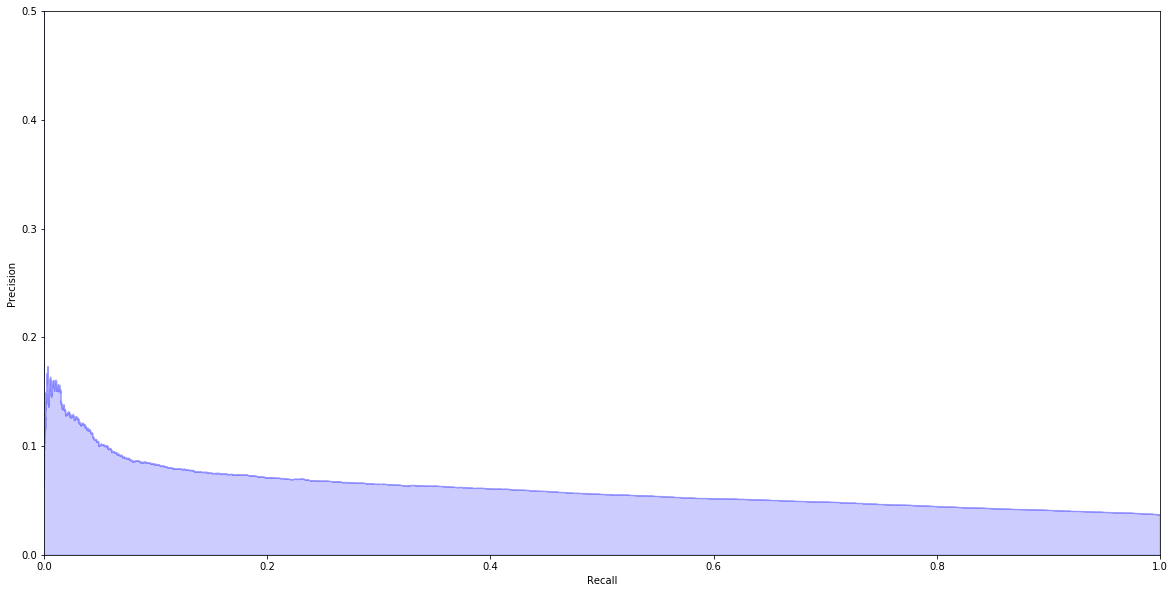

In [26]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.figure(figsize=(20 ,10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 1.0])

-------